# Machine Learning - Prédiction de la note d'un dresseur Pokémon

Ce notebook implémente un **modèle de régression linéaire** pour prédire la note d'un dresseur Pokémon en se basant sur les statistiques et types de ses Pokémon.

## Plan du projet
1. **Import des bibliothèques**
2. **Connexion à la base PostgreSQL**
3. **Exploration et compréhension des données**
4. **Création du dataset de machine learning**
5. **Analyse exploratoire des données**
6. **Préparation des données**
7. **Modélisation et évaluation**
8. **Prédictions**

---

## 1. Import des bibliothèques nécessaires

In [ ]:
# Manipulation et analyse des données
import pandas as pd
import numpy as np

# Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Connexion à la base de données PostgreSQL
import psycopg2
from sqlalchemy import create_engine
import os

print("Import OK")

## 2. Connexion à la base de données PostgreSQL

In [ ]:
# Configuration de la connexion PostgreSQL
DB_CONFIG = {
    'host': 'localhost',
    'database': 'pokedex_db',
    'user': 'postgres',
    'password': '1412pass',
    'port': '5432'
}

# Connexion à PostgreSQL
try:
    connection_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
    engine = create_engine(connection_string)
    
    # Test de la connexion
    test_query = "SELECT 1"
    pd.read_sql_query(test_query, engine)

    print("Connexion OK")

except Exception as e:
    print(f"Erreur : {e}")

Connexion OK


## 3. Exploration et compréhension des données

**Objectif :** Comprendre la structure des tables et leurs relations pour construire notre dataset de machine learning.

**Tables principales :**
- `db_dimtrainer` : informations et scores des dresseurs *variable cible*
- `db_factpokemon` : statistiques détaillées des Pokémon
- `db_pokemontrainers` : relation entre Pokémon et dresseurs
- `db_pokemontypes` : types de chaque Pokémon
- `db_dimtype` : noms des types de Pokémon

In [ ]:
# Tables dresseurs et liaison Pokémon

print("Structure Tables :\n")

# Dresseurs
print("Table Trainer")
query_trainers = "SELECT * FROM db_dimtrainer LIMIT 5"
df_trainers_sample = pd.read_sql_query(query_trainers, engine)
print(f"Colonnes : {list(df_trainers_sample.columns)}")
display(df_trainers_sample)

# table de liaison Pokémon-Dresseurs
print("\n Table de relation Pokémon-Dresseurs")
query_pokemon_trainers = "SELECT * FROM db_pokemontrainers LIMIT 5"
df_pokemon_trainers_sample = pd.read_sql_query(query_pokemon_trainers, engine)
print(f"Colonnes : {list(df_pokemon_trainers_sample.columns)}")
display(df_pokemon_trainers_sample)

Structure Tables :

Table Trainer
Colonnes : ['trainer_id', 'trainer_name', 'trainer_score']


,trainer_id,trainer_name,trainer_score
0,10698,Swimmer♂ Harold,32.24
1,10699,Swimmer♂ Jeffery,53.49
2,3,Ace Duo Jude & Rory,34.55
3,4,Ace Duo Jude & Rory,44.74
4,5,Ace Duo Pike & Shiel,14.82



 Table de relation Pokémon-Dresseurs
Colonnes : ['id', 'pokemon_id', 'trainer_id']


,id,pokemon_id,trainer_id
0,1,1,0
1,2,2,1
2,3,3,2
3,4,4,2
4,5,5,3


In [ ]:
# Table statistiques et types des Pokémon

print("Données des Pokémon :\n")

# Pokémon
print("Table Pokémon :")
query_pokemon_stats = "SELECT * FROM db_factpokemon LIMIT 3"
df_pokemon_stats = pd.read_sql_query(query_pokemon_stats, engine)
print(f"Colonnes : {list(df_pokemon_stats.columns)}")
display(df_pokemon_stats)

# Types des Pokémon
print("\n Table Types Pokémon :")
query_pokemon_types = "SELECT pt.*, dt.type_name FROM db_pokemontypes pt LEFT JOIN db_dimtype dt ON pt.type_id = dt.type_id LIMIT 5"
df_pokemon_types_sample = pd.read_sql_query(query_pokemon_types, engine)
display(df_pokemon_types_sample)

Données des Pokémon :

Table Pokémon :
Colonnes : ['pokemon_id', 'pokemon_name', 'level', 'hp', 'atk', 'def_stat', 'atk_spe', 'def_spe', 'spd', 'pokemon_score']


,pokemon_id,pokemon_name,level,hp,atk,def_stat,atk_spe,def_spe,spd,pokemon_score
0,62,Victreebel,32,104,83,58,80,61,61,21.72
1,95,Ivysaur,32,91,56,56,67,67,54,19.99
2,100,Squirtle,26,68,39,48,40,47,36,14.97



 Table Types Pokémon :


,id,pokemon_id,type_id,type_name
0,1,1,5,feu
1,2,1,16,normal
2,3,2,11,fée
3,4,3,15,combat
4,5,4,1,poison


## 4. Création du dataset de machine learning

**Objectif :** Construire un dataset où chaque ligne représente un dresseur avec :
- Variable cible : `trainer_score`
- Variables : statistiques agrégées de ses Pokémon + distribution des types

In [ ]:
# Chargement des tables en DataFrames

# Dresseurs
df_trainers = pd.read_sql_query("SELECT * FROM db_dimtrainer", engine)
print(f"Dresseurs : {len(df_trainers)} lignes")

# Pokémon
df_pokemon = pd.read_sql_query("SELECT * FROM db_factpokemon", engine)
print(f"Pokémon : {len(df_pokemon)} lignes")

# Relations Pokémon-Dresseurs
df_pokemon_trainers = pd.read_sql_query("SELECT * FROM db_pokemontrainers", engine)
print(f"Relations : {len(df_pokemon_trainers)} lignes")

# Types
df_pokemon_types = pd.read_sql_query("SELECT * FROM db_pokemontypes", engine)
df_types = pd.read_sql_query("SELECT * FROM db_dimtype", engine)
print(f"Types Pokémon : {len(df_pokemon_types)} lignes")
print(f"Types disponibles : {len(df_types)} types")

print("Chargement terminé")

Dresseurs : 11860 lignes
Pokémon : 17358 lignes
Relations : 27250 lignes
Types Pokémon : 57769 lignes
Types disponibles : 18 types
Chargement terminé


In [ ]:
# Construction du dataset pour Machine Learning

print("Jointure de nos Tables ")
# Joindre les tables
df_joined = df_trainers.merge(df_pokemon_trainers, on='trainer_id', how='left')
df_joined = df_joined.merge(df_pokemon, on='pokemon_id', how='left')

# Supprimer les dresseurs sans Pokémon
df_joined = df_joined.dropna(subset=['pokemon_id'])
print(f"Données jointes : {len(df_joined)} lignes")

print("\nAgrégation des statistiques par dresseur")
# Statistiques agrégées par dresseur
df_stats = df_joined.groupby(['trainer_id', 'trainer_name', 'trainer_score']).agg({
    'pokemon_id': 'count',
    'level': 'mean',
    'hp': 'mean',
    'atk': 'mean',
    'def_stat': 'mean',
    'atk_spe': 'mean',
    'def_spe': 'mean',
    'spd': 'mean',
    'pokemon_score': 'mean'
}).round(2)

# Renommer les colonnes (pour plus de cohérence)
df_stats.columns = ['nb_pokemon', 'avg_level', 'avg_hp', 'avg_atk', 'avg_def', 'avg_atk_spe', 'avg_def_spe', 'avg_spd', 'avg_pokemon_score']
df_stats = df_stats.reset_index()

print(f"Dataset statistiques : {len(df_stats)} dresseurs")
display(df_stats.head())

Jointure de nos Tables 
Données jointes : 27250 lignes

Agrégation des statistiques par dresseur
Dataset statistiques : 11443 dresseurs


,trainer_id,trainer_name,trainer_score,nb_pokemon,avg_level,avg_hp,avg_atk,avg_def,avg_atk_spe,avg_def_spe,avg_spd,avg_pokemon_score
0,0,A-list Actor Alonso,36.70,1,60.0,157.0,50.0,68.00,50.00,80.00,116.00,30.58
1,1,A-list Actor Ricardo,18.77,1,30.0,83.0,27.0,36.00,27.00,42.00,60.00,15.64
2,10,Cooltrainer♂,28.89,1,43.0,137.0,93.0,102.00,46.00,46.00,41.00,26.00
3,100,Cooltrainer♀ Brooke,23.45,3,32.0,89.0,52.0,55.67,69.33,57.67,51.33,20.64
4,1000,Ace Trainer♂ Garrett,28.84,2,39.0,105.5,88.5,100.50,63.00,100.50,69.00,28.02


In [ ]:
# Ajout des types de Pokémon

# Joindre types
df_types_named = df_pokemon_types.merge(df_types, on='type_id', how='left')

# Joindre avec les relations dresseur-pokemon
df_trainer_types = df_pokemon_trainers.merge(df_types_named, on='pokemon_id', how='left')

# nbr de types par dresseur
df_type_counts = df_trainer_types.groupby(['trainer_id', 'type_name']).size().reset_index(name='count')

# format pivot
df_types_pivot = df_type_counts.pivot(index='trainer_id', columns='type_name', values='count').fillna(0)

# Préfixer les noms de colonnes
df_types_pivot.columns = [f'type_{col}' for col in df_types_pivot.columns]
df_types_pivot = df_types_pivot.reset_index()

print(f"Types par dresseur : {len(df_types_pivot)} dresseurs")
print(f"Types trouvés : {df_types_pivot.columns.tolist()}")

# Fusion finale
df_ml_final = df_stats.merge(df_types_pivot, on='trainer_id', how='left').fillna(0)

print(f"\nDataset final : {len(df_ml_final)} dresseurs x {len(df_ml_final.columns)} variables")
print(f"Colonnes : {df_ml_final.columns.tolist()}")
display(df_ml_final.head())

Types par dresseur : 11443 dresseurs
Types trouvés : ['trainer_id', 'type_acier', 'type_combat', 'type_dragon', 'type_eau', 'type_feu', 'type_fée', 'type_glace', 'type_insecte', 'type_normal', 'type_plante', 'type_poison', 'type_psy', 'type_roche', 'type_sol', 'type_spectre', 'type_ténèbres', 'type_vol', 'type_électrik']

Dataset final : 11443 dresseurs x 30 variables
Colonnes : ['trainer_id', 'trainer_name', 'trainer_score', 'nb_pokemon', 'avg_level', 'avg_hp', 'avg_atk', 'avg_def', 'avg_atk_spe', 'avg_def_spe', 'avg_spd', 'avg_pokemon_score', 'type_acier', 'type_combat', 'type_dragon', 'type_eau', 'type_feu', 'type_fée', 'type_glace', 'type_insecte', 'type_normal', 'type_plante', 'type_poison', 'type_psy', 'type_roche', 'type_sol', 'type_spectre', 'type_ténèbres', 'type_vol', 'type_électrik']


,trainer_id,trainer_name,trainer_score,nb_pokemon,avg_level,avg_hp,avg_atk,avg_def,avg_atk_spe,avg_def_spe,...,type_normal,type_plante,type_poison,type_psy,type_roche,type_sol,type_spectre,type_ténèbres,type_vol,type_électrik
0,0,A-list Actor Alonso,36.70,1,60.0,157.0,50.0,68.00,50.00,80.00,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1,A-list Actor Ricardo,18.77,1,30.0,83.0,27.0,36.00,27.00,42.00,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2,10,Cooltrainer♂,28.89,1,43.0,137.0,93.0,102.00,46.00,46.00,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,100,Cooltrainer♀ Brooke,23.45,3,32.0,89.0,52.0,55.67,69.33,57.67,...,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0
4,1000,Ace Trainer♂ Garrett,28.84,2,39.0,105.5,88.5,100.50,63.00,100.50,...,0.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0


## 5. Analyse exploratoire des données

**Objectif :** Analyser la qualité et la distribution des données pour préparer le machine learning :
- Vérifier les valeurs manquantes
- Analyser la distribution de la variable cible
- Examiner les corrélations entre variables

In [ ]:
# Analyse de base du dataset

print("Informations générales :")
print(f"Shape : {df_ml_final.shape}")
print(f"Variables : {df_ml_final.shape[1]}")
print(f"Observations : {df_ml_final.shape[0]}")

print("\nTypes de données :")
print(df_ml_final.dtypes.value_counts())

print("\nValeurs manquantes :")
missing_values = df_ml_final.isnull().sum()
print(f"Total : {missing_values.sum()}")
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("Aucune valeur manquante")

print("\nStatistiques descriptives de la variable cible :")
target_stats = df_ml_final['trainer_score'].describe()
print(target_stats)

Informations générales :
Shape : (11443, 30)
Variables : 30
Observations : 11443

Types de données :
float64    27
object      2
int64       1
Name: count, dtype: int64

Valeurs manquantes :
Total : 0
Aucune valeur manquante

Statistiques descriptives de la variable cible :
count    11443.000000
mean        29.133475
std         15.244695
min          2.300000
25%         18.495000
50%         26.630000
75%         38.735000
max        117.760000
Name: trainer_score, dtype: float64


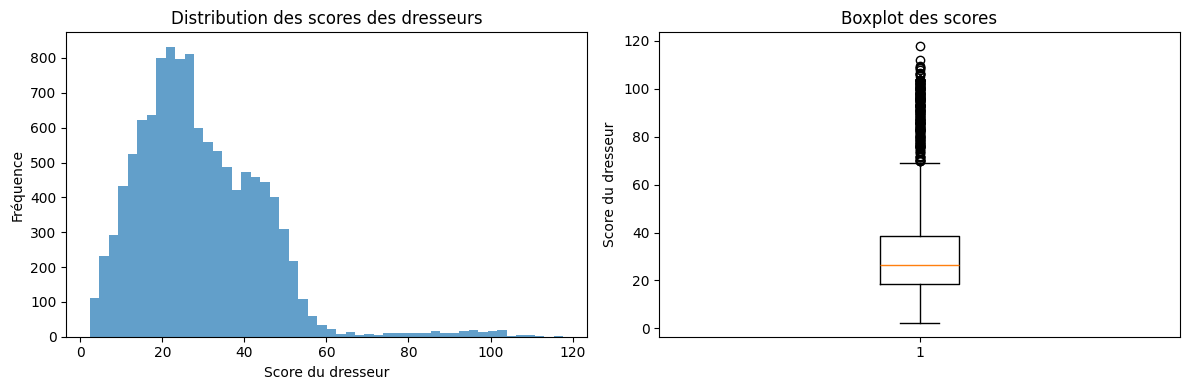

Observations :
- Score moyen : 29.13
- Score médian : 26.63
- Écart-type : 15.24
- Distribution : Normal même si quelques valeurs élevées


In [ ]:
# Visualisation de la variable cible

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_ml_final['trainer_score'], bins=50, alpha=0.7)
plt.title('Distribution des scores des dresseurs')
plt.xlabel('Score du dresseur')
plt.ylabel('Fréquence')

plt.subplot(1, 2, 2)
plt.boxplot(df_ml_final['trainer_score'])
plt.title('Boxplot des scores')
plt.ylabel('Score du dresseur')

plt.tight_layout()
plt.show()

print("Observations :")
print(f"- Score moyen : {df_ml_final['trainer_score'].mean():.2f}")
print(f"- Score médian : {df_ml_final['trainer_score'].median():.2f}")
print(f"- Écart-type : {df_ml_final['trainer_score'].std():.2f}")
print(f"- Distribution : Normal même si quelques valeurs élevées")

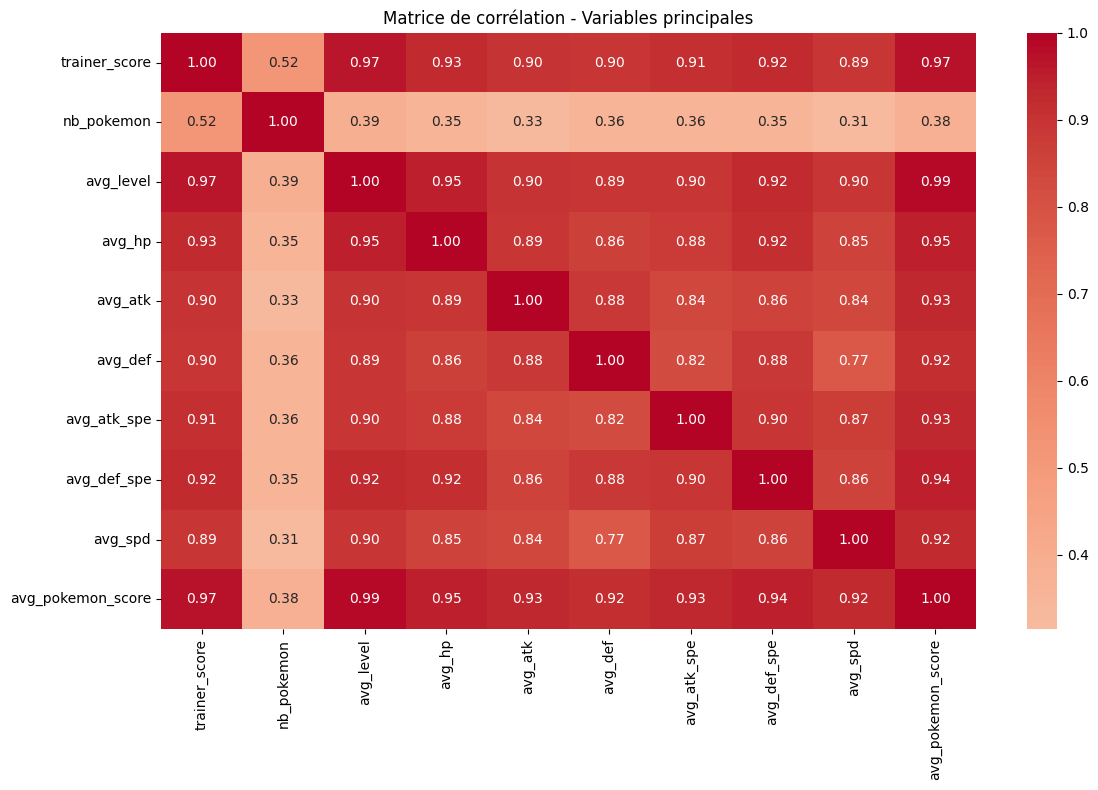

Top 5 variables corrélées avec le score du dresseur :
1. avg_pokemon_score: 0.972
2. avg_level: 0.965
3. avg_hp: 0.926
4. avg_def_spe: 0.921
5. avg_atk_spe: 0.910


In [ ]:
# Analyse des corrélations entre variables

# Sélectionner les variables numériques principales
variables_stats = ['trainer_score', 'nb_pokemon', 'avg_level', 'avg_hp', 'avg_atk', 'avg_def', 'avg_atk_spe', 'avg_def_spe', 'avg_spd', 'avg_pokemon_score']
df_correlations = df_ml_final[variables_stats]

# Matrice de corrélation
plt.figure(figsize=(12, 8))
correlation_matrix = df_correlations.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matrice de corrélation - Variables principales')
plt.tight_layout()
plt.show()

# Top 5 des corrélations avec le score du dresseur
correlations_score = correlation_matrix['trainer_score'].sort_values(ascending=False)
print("Top 5 variables corrélées avec le score du dresseur :")
for i, (var, corr) in enumerate(correlations_score[1:6].items(), 1):
    print(f"{i}. {var}: {corr:.3f}")

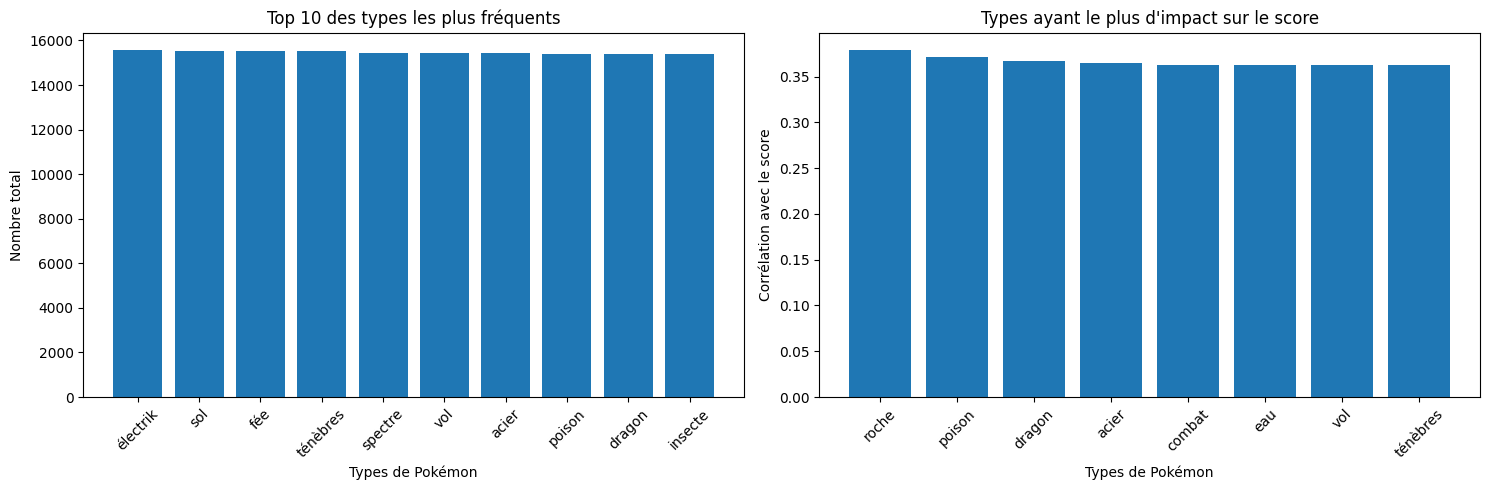

Observations :
- Type le plus fréquent : électrik (15565.0 occurrences)
- Type avec meilleur impact : roche (corrélation: 0.379)


In [ ]:
# Analyse des types de Pokémon les plus fréquents

# Types les plus fréquents
types_cols = [col for col in df_ml_final.columns if col.startswith('type_')]
types_totaux = df_ml_final[types_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
top_10_types = types_totaux.head(10)
plt.bar(range(len(top_10_types)), top_10_types.values)
plt.title('Top 10 des types les plus fréquents')
plt.xlabel('Types de Pokémon')
plt.ylabel('Nombre total')
plt.xticks(range(len(top_10_types)), [t.replace('type_', '') for t in top_10_types.index], rotation=45)

plt.subplot(1, 2, 2)
# Impact des types sur le score (corrélation)
types_correlations = df_ml_final[types_cols + ['trainer_score']].corr()['trainer_score'].drop('trainer_score').sort_values(ascending=False)
top_types_impact = types_correlations.head(8)
plt.bar(range(len(top_types_impact)), top_types_impact.values)
plt.title('Types ayant le plus d\'impact sur le score')
plt.xlabel('Types de Pokémon')
plt.ylabel('Corrélation avec le score')
plt.xticks(range(len(top_types_impact)), [t.replace('type_', '') for t in top_types_impact.index], rotation=45)

plt.tight_layout()
plt.show()

print("Observations :")
print(f"- Type le plus fréquent : {types_totaux.index[0].replace('type_', '')} ({types_totaux.iloc[0]} occurrences)")
print(f"- Type avec meilleur impact : {top_types_impact.index[0].replace('type_', '')} (corrélation: {top_types_impact.iloc[0]:.3f})")

## 6. Préparation des données

**Objectif :** Préparer les données pour le modèle de régression linéaire :
- Sélectionner les variables 
- Séparer variables (impactante) et variable cible
- Diviser en ensembles d'entraînement et de test

In [ ]:
# Sélection des variables pour le modèle

# Variables à exclure (identifiants et noms)
variables_exclues = ['trainer_id', 'trainer_name']

# Toutes les variables numériques (statistiques + types)
variables_explicatives = [col for col in df_ml_final.columns if col not in variables_exclues + ['trainer_score']]

print(f"Total : {len(variables_explicatives)} variables sélectionnées")
print("\nStatistiques Pokémon :")
stats_vars = [col for col in variables_explicatives if col.startswith('avg_') or col.startswith('nb_')]
print(stats_vars)
print(f"\nTypes Pokémon :")
types_vars = [col for col in variables_explicatives if col.startswith('type_')]
print(f"{len(types_vars)} types : {types_vars[:5]}...")

# Préparation des datasets X et y
X = df_ml_final[variables_explicatives]
y = df_ml_final['trainer_score']

print(f"\nDataset préparé :")
print(f"X (variables sélectionnées) : {X.shape}")
print(f"y (variable cible) : {y.shape}")

Total : 27 variables sélectionnées

Statistiques Pokémon :
['nb_pokemon', 'avg_level', 'avg_hp', 'avg_atk', 'avg_def', 'avg_atk_spe', 'avg_def_spe', 'avg_spd', 'avg_pokemon_score']

Types Pokémon :
18 types : ['type_acier', 'type_combat', 'type_dragon', 'type_eau', 'type_feu']...

Dataset préparé :
X (variables sélectionnées) : (11443, 27)
y (variable cible) : (11443,)


In [ ]:
# Entraînement et test

# 80 entraînement / 20 test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print("Division des données :")
print(f"Entraînement : {X_train.shape[0]} observations")
print(f"Test : {X_test.shape[0]} observations")
print(f"Proportion test : {X_test.shape[0] / len(X) * 100:.1f}%")

print(f"\nStatistiques de la variable cible :")
print(f"Train - moyenne : {y_train.mean():.2f}, std : {y_train.std():.2f}")
print(f"Test - moyenne : {y_test.mean():.2f}, std : {y_test.std():.2f}")

Division des données :
Entraînement : 9154 observations
Test : 2289 observations
Proportion test : 20.0%

Statistiques de la variable cible :
Train - moyenne : 29.27, std : 15.36
Test - moyenne : 28.59, std : 14.76


## 7. Modélisation et évaluation

**Objectif :** Entraîner le modèle de régression linéaire et évaluer ses performances

In [ ]:
# Entraînement du modèle de régression linéaire

# Création et entraînement du modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("Modèle entraîné")
print(f"Coefficient de détermination (R²) sur train : {model.score(X_train, y_train):.4f}")
print(f"Coefficient de détermination (R²) sur test : {model.score(X_test, y_test):.4f}")

# Métriques détaillées
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"\nMétriques d'évaluation :")
print(f"RMSE - Train : {train_rmse:.3f}, Test : {test_rmse:.3f}")
print(f"MAE - Train : {train_mae:.3f}, Test : {test_mae:.3f}")

Modèle entraîné
Coefficient de détermination (R²) sur train : 0.9755
Coefficient de détermination (R²) sur test : 0.9770

Métriques d'évaluation :
RMSE - Train : 2.406, Test : 2.237
MAE - Train : 1.762, Test : 1.699


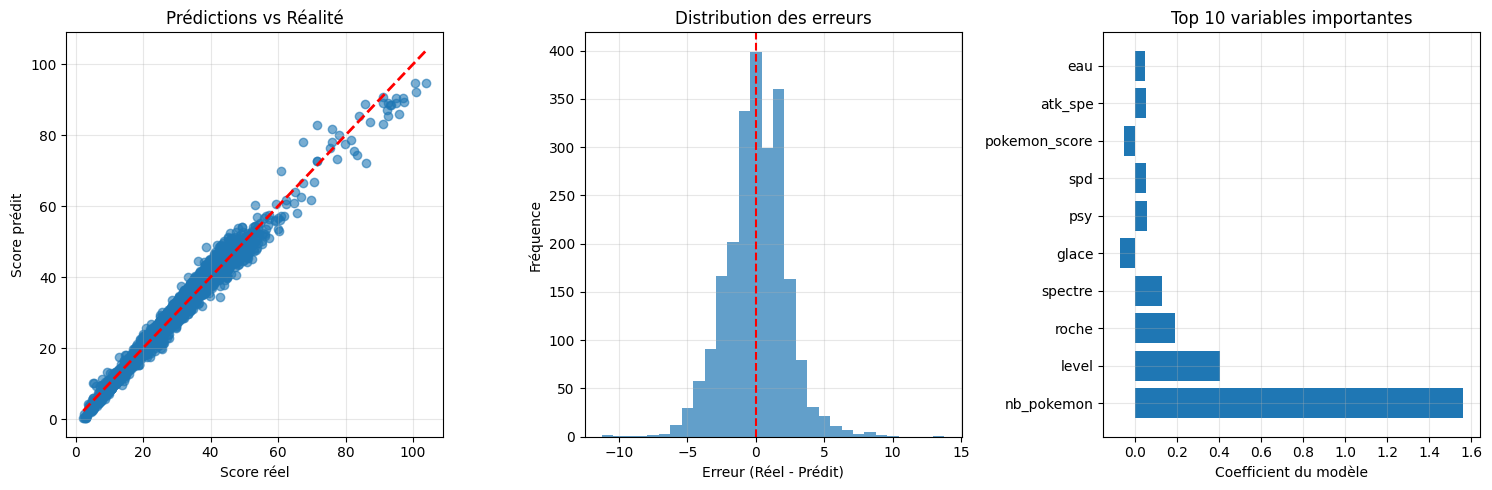

- Variable la plus importante : nb_pokemon
- correspond au nombre de pokemon du chaque dresseur


In [ ]:
# Visualisation des performances du modèle

plt.figure(figsize=(15, 5))

# Graphique 1 : Prédictions vs Réalité
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Score réel')
plt.ylabel('Score prédit')
plt.title('Prédictions vs Réalité')
plt.grid(True, alpha=0.3)

# Graphique 2 : Distribution des erreurs
plt.subplot(1, 3, 2)
erreurs = y_test - y_pred_test
plt.hist(erreurs, bins=30, alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Erreur (Réel - Prédit)')
plt.ylabel('Fréquence')
plt.title('Distribution des erreurs')
plt.grid(True, alpha=0.3)

# Graphique 3 : Importance des variables (coefficients)
plt.subplot(1, 3, 3)
# les 10 coefficients les plus importants en valeur absolue
coefficients = pd.Series(model.coef_, index=X.columns)
top_coefficients = coefficients.abs().sort_values(ascending=False).head(10)
plt.barh(range(len(top_coefficients)), [coefficients[var] for var in top_coefficients.index])
plt.yticks(range(len(top_coefficients)), [var.replace('type_', '').replace('avg_', '') for var in top_coefficients.index])
plt.xlabel('Coefficient du modèle')
plt.title('Top 10 variables importantes')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"- Variable la plus importante : {top_coefficients.index[0]}")
print(f"- correspond au nombre de pokemon du chaque dresseur")

## 8. Prédictions et conclusion

**Objectif :** Utiliser le modèle pour prédire la note de nouveaux dresseurs

In [ ]:
# RÉSUMÉ POUR PRÉSENTATION

print("        PRÉSENTATION : PRÉDICTION NOTE DRESSEUR POKÉMON")
print("Variable à prédire (Y) : Score du dresseur (trainer_score)")
print("Variables explicatives (X) : Statistiques + types des Pokémon du dresseur")
print("Problème : Régression linéaire")
print(f"Dataset : {len(df_ml_final)} dresseurs, {len(X.columns)} variables")

print("\nPROCESSUS ETL")
print("1.EXTRACT : Données depuis PostgreSQL (5 tables)")
print(" db_dimtrainer (dresseurs)")
print(" db_factpokemon (statistiques Pokémon)")
print(" db_pokemontrainers (relations)")
print(" db_pokemontypes + db_dimtype (types)")

print("2.TRANSFORM : Jointures et agrégations pandas")
print(" Jointure des tables par clés étrangères")
print(" Agrégation par dresseur (moyennes des stats)")
print(" Transformation pivot pour les types")

print("3.LOAD : Dataset final pour machine learning")


print("\n MODÉLISATION TECHNIQUE")
print(" Régression linéaire (sklearn)")
print(" Division : 80% train / 20% test")
print(" Variables : 9 statistiques + 18 types de Pokémon")

print("\n RÉSULTATS ET INTERPRÉTATION")
print(f"R² = {model.score(X_test, y_test):.1%} (Presque PARFAIT)")
print("Conclusion : Les stats des Pokémon prédisent très bien le score du dresseur")

        PRÉSENTATION : PRÉDICTION NOTE DRESSEUR POKÉMON
Variable à prédire (Y) : Score du dresseur (trainer_score)
Variables explicatives (X) : Statistiques + types des Pokémon du dresseur
Problème : Régression linéaire
Dataset : 11443 dresseurs, 27 variables

PROCESSUS ETL
1.EXTRACT : Données depuis PostgreSQL (5 tables)
 db_dimtrainer (dresseurs)
 db_factpokemon (statistiques Pokémon)
 db_pokemontrainers (relations)
 db_pokemontypes + db_dimtype (types)
2.TRANSFORM : Jointures et agrégations pandas
 Jointure des tables par clés étrangères
 Agrégation par dresseur (moyennes des stats)
 Transformation pivot pour les types
3.LOAD : Dataset final pour machine learning

 MODÉLISATION TECHNIQUE
 Régression linéaire (sklearn)
 Division : 80% train / 20% test
 Variables : 9 statistiques + 18 types de Pokémon

 RÉSULTATS ET INTERPRÉTATION
R² = 97.7% (Presque PARFAIT)
Conclusion : Les stats des Pokémon prédisent très bien le score du dresseur
